In [29]:
import numpy as np
import time
import os
import sys
import h5py
import ipywidgets as widgets
import matplotlib.pyplot as plt
import scipy
import scipy.io
from scipy.interpolate import interpn
sys.path.insert(0, '../../src')

from prepare_data.h5functions import save_to_h5
from utils.mag_transform_utils import *
from utils.evaluate_utils import get_boundaries, temporal_linear_interpolation_np, spatial3D_NN_interpolation
plt.rcParams['figure.figsize'] = [10, 8]

In [30]:
vel_colnames = ['u', 'v','w']
venc_colnames = [ 'u_max', 'v_max', 'w_max']
mag_colnames = ['mag_u', 'mag_v', 'mag_w']

In [31]:
insilico_model = 'M5'
invivo_model = 'P03'


data_dir = '/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/data'

# load 
in_vivo_path = f'{data_dir}/PIA/THORAX/{invivo_model}/h5/{invivo_model}.h5'
in_vivo_path_LV = f'{data_dir}/PIA/THORAX/{invivo_model}/maskLV.mat'
in_silico_path = f'{data_dir}/CARDIAC/{insilico_model}_2mm_step2_static_dynamic.h5'

name_in_vivo   = os.path.basename(in_vivo_path)[:-2]
name_in_silico = os.path.basename(in_silico_path)[:2]
in_vivo = {}
in_silico = {}
vencs = {}


# in_vivo['mask_LV'] = scipy.io.loadmat('file.mat')

# load data
with h5py.File(in_vivo_path, mode = 'r' ) as p1:
    with h5py.File(in_silico_path, mode = 'r' ) as p2:
        with h5py.File(in_vivo_path_LV, mode = 'r' ) as p3:
            print(p1.keys(), p2.keys())
            # load mask and distriguish between complete and left ventricle (LV) mask 
            in_vivo['mask'] =  np.asarray(p1['mask']).squeeze()
            in_vivo['mask_LV'] = np.asarray(p3['mask']).squeeze()
            in_silico['mask'] = np.asarray(p2['mask']).squeeze()

            for mag,vel, venc in zip(mag_colnames,vel_colnames, venc_colnames):
                in_vivo[mag]   = np.asarray(p1[mag])
                in_silico[mag] = np.asarray(p2[mag])

                in_vivo[vel]   = np.asarray(p1[vel])
                in_silico[vel] = np.asarray(p2[vel])

                in_vivo[f'{vel}_fluid']   = np.multiply(in_vivo[vel], in_vivo['mask'])
                in_silico[f'{vel}_fluid'] = np.multiply(in_silico[vel], in_silico['mask'])
            
            in_vivo['bounds_LV'], _ = get_boundaries(in_vivo['mask_LV']) # carful here we take only the boundary of left ventricle mask
            in_vivo['bounds'], _ = get_boundaries(in_vivo['mask'])
            in_silico['bounds'], _ = get_boundaries(in_silico['mask'])           

# load an look at data
frame = 10

# load complete mask
mask_v =  in_vivo['mask'][frame].copy()
mask_s =  in_silico['mask'][frame].copy()

#load boundary
bounds_v = in_vivo['bounds_LV'][frame].copy()
bounds_s = in_silico['bounds'][frame].copy()


<KeysViewHDF5 ['dx', 'mag_u', 'mag_v', 'mag_w', 'mask', 'u', 'u_max', 'v', 'v_max', 'w', 'w_max']> <KeysViewHDF5 ['dx', 'mag_u', 'mag_v', 'mag_w', 'mask', 'u', 'u_max', 'v', 'v_max', 'w', 'w_max']>


In [32]:

from scipy.interpolate import RegularGridInterpolator
# ----------set LV mask---------


# load/get left vetricle mask
mask_LV_s =  mask_s.copy()

#M1P01
# mask_LV_s[30:, :, :] = 0 #This needs to be adapted for every part
# mask_LV_s[:, 47:, :] = 0
# mask_LV_s[:, :, :30] = 0

#M3P03
# mask_LV_s[40:, :, :] = 0 #This needs to be adapted for every part
# mask_LV_s[:, 60:, :] = 0
# mask_LV_s[:, :, :35] = 0

#M4P02
# mask_LV_s[40:, :, :] = 0 #This needs to be adapted for every part
# mask_LV_s[:, 40:, :] = 0
# mask_LV_s[:, :, :38] = 0


#M2P04
# mask_LV_s[50:, :, :] = 0 #This needs to be adapted for every part
# mask_LV_s[:, 60:, :] = 0
# mask_LV_s[:, :, :40] = 0

#M5P05
mask_LV_s[31:, :, :] = 0 #This needs to be adapted for every part
mask_LV_s[:, 45:, :] = 0
mask_LV_s[:, :, :27] = 0


mask_LV_v = in_vivo['mask_LV'][frame]

print(mask_LV_s.shape, mask_v.shape, mask_LV_v.shape)

def spatial3D_NN_interpolation2(lr, hr_shape, method = 'linear'):
    


    x_lr = np.arange(0, lr.shape[0])
    y_lr = np.arange(0, lr.shape[1])
    z_lr = np.arange(0, lr.shape[2])

    x_hr = np.arange(0, lr.shape[0], 0.5)
    x_hr[-1] = x_hr[-2]
    y_hr = np.arange(0, lr.shape[1], 0.5)
    y_hr[-1] = y_hr[-2]
    z_hr = np.arange(0, lr.shape[2], 0.5)
    z_hr[-1] = z_hr[-2]
    xg, yg ,zg = np.meshgrid(x_hr, y_hr, z_hr, indexing='ij', sparse=True)

    interp = RegularGridInterpolator((x_lr, y_lr, z_lr), lr, method = method)
    interpolate = interp((xg, yg, zg)).reshape(hr_shape)

    # xg, yg ,zg = np.mgrid[0:hr_shape[0], 0:hr_shape[1], 0:hr_shape[2]]
    # coord = np.array([xg.flatten(), yg.flatten() ,zg.flatten()])

    # interpolate = scipy.ndimage.map_coordinates(lr,coord, mode='nearest').reshape(hr_shape)

    # interpolate[np.where(interpolate < 1e-6)] = 0
    print('nonzero:', np.count_nonzero(interpolate), 'before:', np.count_nonzero(lr))
    print('min/max:', np.min(interpolate), np.max(interpolate))
    print(np.unique(interpolate))
    return interpolate


# ----------set scaling and rotation parameters mask---------
def indivial_transformation_scale_rotate(data, scale, method = 'nearest'):
    # 1. scaling
    scale = [2, 2, 2]    
    data_transformed = spatial3D_NN_interpolation2(data, (mask_LV_v.shape[0]*scale[0], mask_LV_v.shape[1]*scale[1], mask_LV_v.shape[2]*scale[2]), method = method)
    
    #2. rotation
    idx_rotation = np.index_exp[::-1, ::1, ::1]
    data_transformed = data_transformed[idx_rotation]
    
    return data_transformed

#--------------transformation--------------
print('No. points in mask: invivo /insilico LV', np.count_nonzero(mask_LV_v), '/', np.count_nonzero(mask_LV_s))

#transform the invivo data
mask_v_transformed   = indivial_transformation_scale_rotate(mask_LV_v, [2, 2, 2], method = 'nearest')
bounds_v_transformed = indivial_transformation_scale_rotate(bounds_v, [2, 2, 2], method = 'nearest')

mask_v_transformed[np.where(mask_v_transformed>= 0.5)] = 1
mask_v_transformed[np.where(mask_v_transformed< 0.5)] = 0

bounds_v_transformed[np.where(bounds_v_transformed>= 0.5)] = 1
bounds_v_transformed[np.where(bounds_v_transformed< 0.5)] = 0

print('No. points in mask transformed: invivo /insilico', np.count_nonzero(mask_v_transformed), '/', np.count_nonzero(mask_LV_s))


idx_insilico, idx_t_insilico, idx_invivo, idx_t_invivo = idx_invivo_to_insilico(mask_v_transformed, mask_LV_s)


# make copy of  
combined_LV_mask = np.array(mask_s.copy(), dtype=np.uint8)

#insert invivo into insilico
combined_LV_mask[idx_insilico] += np.asarray(mask_v_transformed[idx_invivo]*2, np.uint8)
print(np.unique(combined_LV_mask), np.unique(mask_v_transformed[idx_invivo]*2))

#-----------combine mask including aorta of invivo data with boundary of mask---------
# combine the boundary masks for visualization
combined_boundary_mask = np.array(bounds_s.copy(), dtype=np.uint8)
bounds_v_all_transformed = indivial_transformation_scale_rotate(in_vivo['bounds'][frame], [2, 2, 2], method = 'nearest')

bounds_v_all_transformed[np.where(bounds_v_all_transformed>= 0.5)] = 1
bounds_v_all_transformed[np.where(bounds_v_all_transformed< 0.5)] = 0

combined_boundary_mask[idx_insilico] += np.asarray(bounds_v_all_transformed[idx_invivo]*2, np.uint8)

print("Shape of invivo transformed in scale and rotated", mask_v_transformed.shape, 'combined shape, ie. insilico' ,combined_LV_mask.shape)


(70, 70, 71) (44, 108, 160) (44, 108, 160)
No. points in mask: invivo /insilico LV 3929 / 18554
nonzero: 31432 before: 3929
min/max: 0.0 1.0
[0. 1.]
nonzero: 8712 before: 1089
min/max: 0.0 1.0
[0. 1.]
No. points in mask transformed: invivo /insilico 31432 / 18554
center of insilico LV  17 27 45
center of invivo LV 22 102 204
insilico indices: x min/max 0 69 y min/max 0 69 z min/max 0 70
[0 1 2 3] [0. 2.]
nonzero: 27408 before: 3426
min/max: 0.0 1.0
[0. 1.]
Shape of invivo transformed in scale and rotated (88, 216, 320) combined shape, ie. insilico (70, 70, 71)



### Transformation
 1. Find LV in insilico mask and define LV mask there
 2. See if in invivo data needs to be scaled and rotated: Set parameters (e.g. Compare number of voxels. If necessary scale in vivo by using interpolation (NN, linear ..))
 2. Find center point of gravity in both LV masks and get cropping index
 3. Insert in vivo mask such that the midpoints overlap , i.e. [mid_c -patch_size_x]
 4. Save as h5 file

In [33]:
print(bounds_v_all_transformed[idx_invivo].shape)

#M1P01 - (71, 69, 75)
#M4P02 -(61, 57, 83)
#M3P03 - (71, 81, 83)
#M2P04 - (83, 59, 95)

(69, 69, 70)


## Visualization

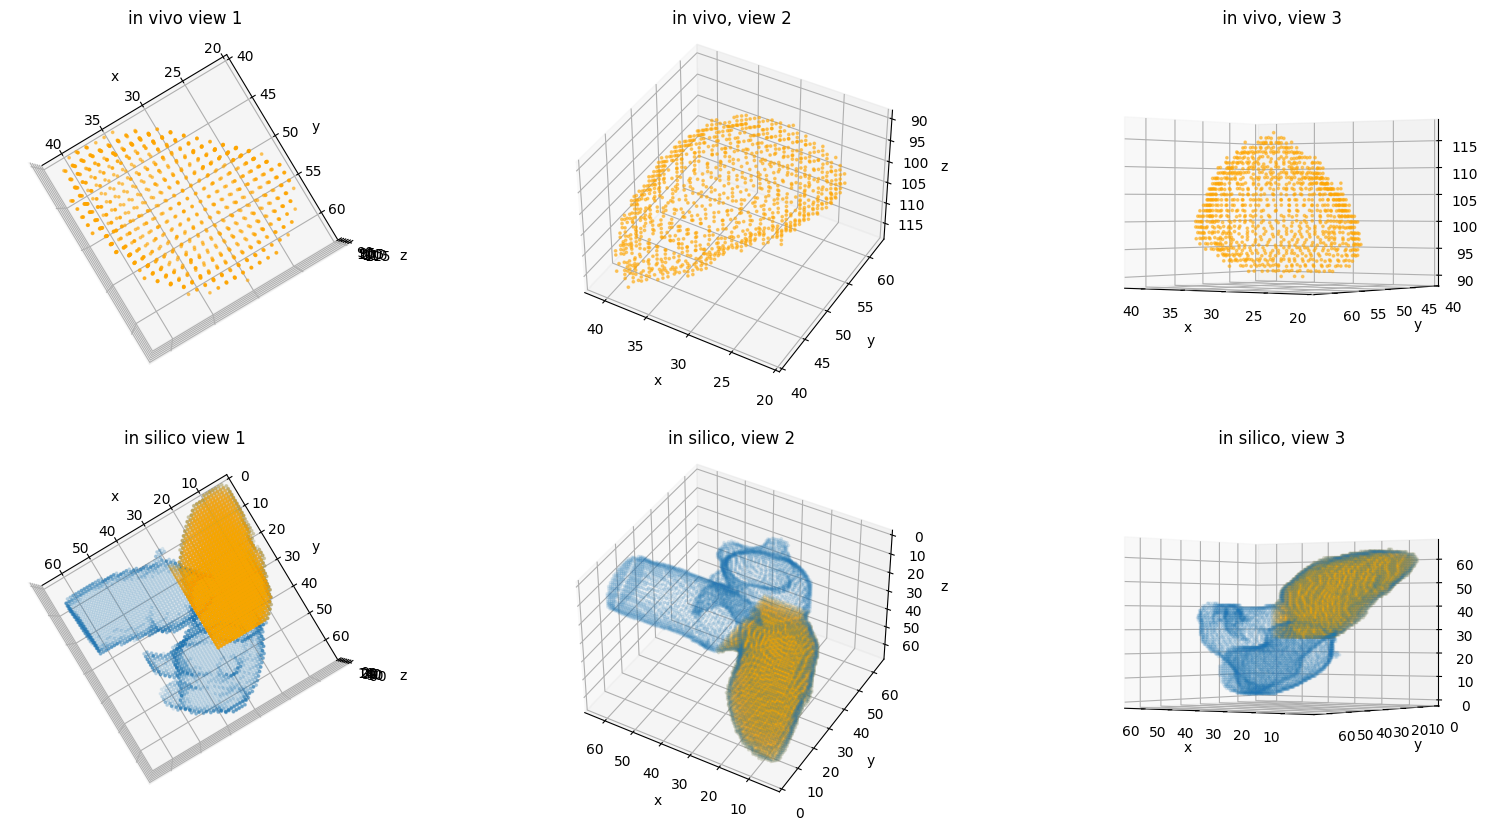

In [34]:
# Show the data stes which should be mapped
#--------------------Plot 3D angles----------------------

fig = plt.figure(figsize=(20,10))
#--------------plot 1------------------
ax = fig.add_subplot(2, 3, 1, projection='3d')
x_sv, y_sv, z_sv = np.where(bounds_v  ==1)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.5, color = 'orange') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'in vivo view 1')
ax.view_init(-270, 60)

#--------------plot 2------------------
ax = fig.add_subplot(2, 3, 2, projection='3d')
x_sv, y_sv, z_sv = np.where(bounds_v  ==1)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.5, color = 'orange') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'in vivo, view 2')
ax.view_init(-140, 60)

#--------------plot 3------------------
ax = fig.add_subplot(2, 3, 3, projection='3d')
x_sv, y_sv, z_sv = np.where(bounds_v  ==1)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.5, color = 'orange') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f' in vivo, view 3')
ax.view_init(0, 125)

#-----------------in silico-------------------------------------
#--------------plot 4------------------
ax = fig.add_subplot(2, 3, 4, projection='3d')
x_sv, y_sv, z_sv = np.where(bounds_s  ==1)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.1) 
x_s_LV, y_s_LV, z_s_LV = np.where(mask_LV_s ==1)
ax.scatter3D(x_s_LV, y_s_LV, z_s_LV, s= 3, alpha = 0.1, color = 'orange') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'in silico view 1')
ax.view_init(-270, 60)

#--------------plot 5------------------
ax = fig.add_subplot(2, 3, 5, projection='3d')
x_sv, y_sv, z_sv = np.where(bounds_s  ==1)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.1) 
x_s_LV, y_s_LV, z_s_LV = np.where(mask_LV_s ==1)
ax.scatter3D(x_s_LV, y_s_LV, z_s_LV, s= 3, alpha = 0.1, color = 'orange') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'in silico, view 2')
ax.view_init(-140, 60)

#--------------plot 6------------------
ax = fig.add_subplot(2, 3, 6, projection='3d')
x_sv, y_sv, z_sv = np.where(bounds_s  ==1)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.1) 
x_s_LV, y_s_LV, z_s_LV = np.where(mask_LV_s ==1)
ax.scatter3D(x_s_LV, y_s_LV, z_s_LV, s= 3, alpha = 0.1, color = 'orange') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f' in silico, view 3')
ax.view_init(0, 125)

plt.show()





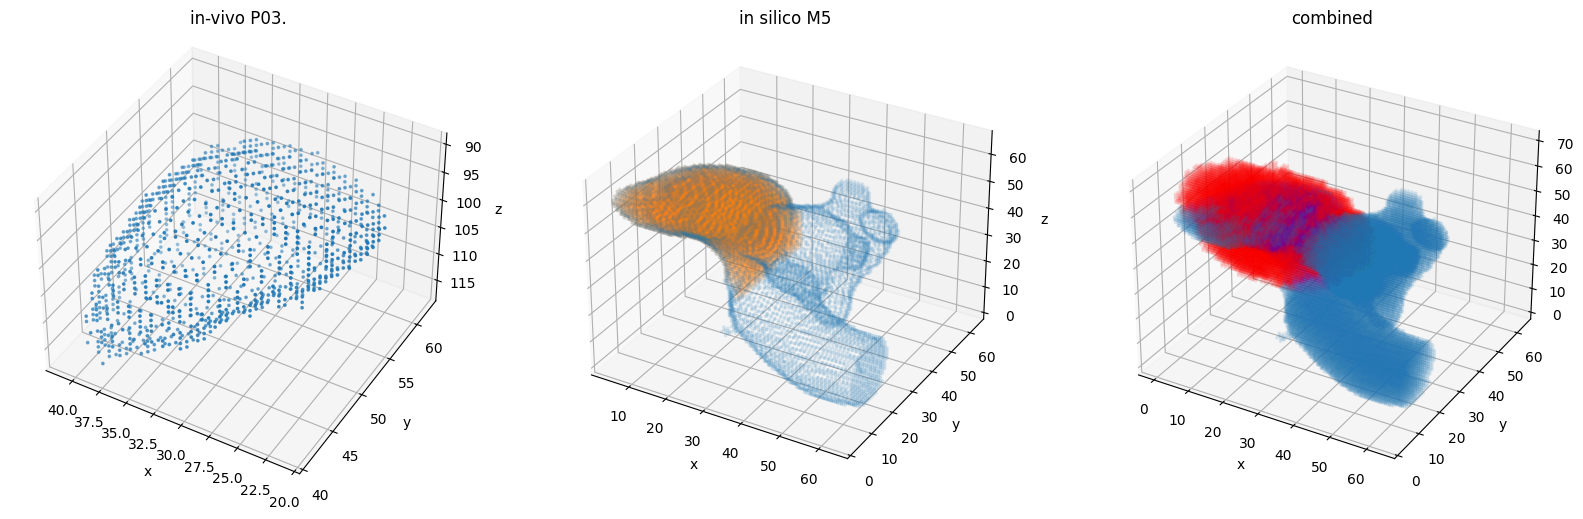

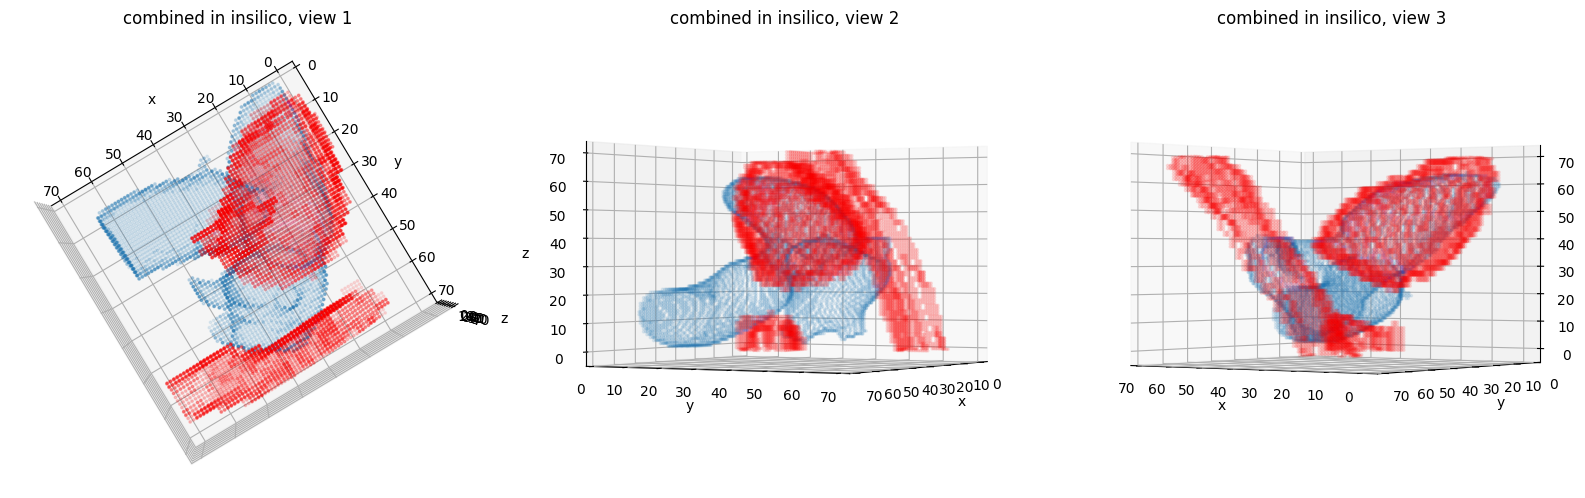

In [35]:
#---------Plot results-----------------


fig = plt.figure(figsize=(20,10))
#--------------plot 1------------------
ax = fig.add_subplot(1, 3, 1, projection='3d')
x_v, y_v, z_v = np.where(bounds_v ==1)
ax.scatter3D(x_v, y_v, z_v, s= 3) 

plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'in-vivo {name_in_vivo}')
ax.view_init(-140, 60)


#--------------plot 2------------------
ax = fig.add_subplot(1, 3, 2, projection='3d')
x_s, y_s, z_s = np.where(bounds_s ==1)
ax.scatter3D(x_s, y_s, z_s, s= 3, alpha = 0.1) 
x_s_LV, y_s_LV, z_s_LV = np.where(mask_LV_s ==1)
ax.scatter3D(x_s_LV, y_s_LV, z_s_LV, s= 3, alpha = 0.1) 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'in silico {name_in_silico}')


#--------------plot 3------------------
ax = fig.add_subplot(1, 3, 3, projection='3d')
x_sv, y_sv, z_sv = np.where(combined_LV_mask  ==1)
x_sv2, y_sv2, z_sv2 = np.where(combined_LV_mask == 2)
x_sv3, y_sv3, z_sv3 = np.where(combined_LV_mask == 3)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.1) 
ax.scatter3D(x_sv2, y_sv2, z_sv2, s= 3, alpha = 0.1, color = 'red') 
ax.scatter3D(x_sv3, y_sv3, z_sv3, s= 3, alpha = 0.1, color = 'purple') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'combined')
plt.show()

#--------------------Plot 3D angles----------------------

fig = plt.figure(figsize=(20,10))
#--------------plot 1------------------
ax = fig.add_subplot(1, 3, 1, projection='3d')
x_sv, y_sv, z_sv = np.where(combined_boundary_mask  ==1)
x_sv2, y_sv2, z_sv2 = np.where(combined_boundary_mask == 2)
x_sv3, y_sv3, z_sv3 = np.where(combined_boundary_mask == 3)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.1) 
ax.scatter3D(x_sv2, y_sv2, z_sv2, s= 3, alpha = 0.1, color = 'red') 
ax.scatter3D(x_sv3, y_sv3, z_sv3, s= 3, alpha = 0.1, color = 'purple') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'combined in insilico, view 1')
ax.view_init(-270, 60)

#--------------plot 2------------------
ax = fig.add_subplot(1, 3, 2, projection='3d')
x_sv, y_sv, z_sv = np.where(combined_boundary_mask  ==1)
x_sv2, y_sv2, z_sv2 = np.where(combined_boundary_mask == 2)
x_sv3, y_sv3, z_sv3 = np.where(combined_boundary_mask == 3)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.1) 
ax.scatter3D(x_sv2, y_sv2, z_sv2, s= 3, alpha = 0.1, color = 'red') 
ax.scatter3D(x_sv3, y_sv3, z_sv3, s= 3, alpha = 0.1, color = 'purple') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'combined in insilico, view 2')
ax.view_init(0, 30)
# ax.view_init(-140, 60)

#--------------plot 3------------------
ax = fig.add_subplot(1, 3, 3, projection='3d')
x_sv, y_sv, z_sv = np.where(combined_boundary_mask  == 1)
x_sv2, y_sv2, z_sv2 = np.where(combined_boundary_mask == 2)
x_sv3, y_sv3, z_sv3 = np.where(combined_boundary_mask == 3)
ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.1) 
ax.scatter3D(x_sv2, y_sv2, z_sv2, s= 3, alpha = 0.1, color = 'red') 
ax.scatter3D(x_sv3, y_sv3, z_sv3, s= 3, alpha = 0.1, color = 'purple') 
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title(f'combined in insilico, view 3')
ax.view_init(0, 125)
plt.show()

In [ ]:
#trying different views
#box is for visalization of cropping and transformation into insilico shape
temp_b = np.ones_like(mask_v_transformed) #indivial_transformation_scale_rotate(box_invivo, scale = [2,2,2], interpolation='NN')
temp_b[1:-2, 1:-2, 1:-2] = 0
box_transformed = np.zeros_like(mask_s)
box_transformed[idx_insilico] += np.array(temp_b[idx_invivo], np.uint16)
print(np.unique(box_transformed), np.unique(temp_b))

#-----------combine mask including aorta of invivo data---------
combined_masks = np.array(mask_s.copy(), dtype=np.uint8)
mask_v_all_transformed = indivial_transformation_scale_rotate(mask_v, [2, 2, 2])
#insert invivo into insilico
combined_masks[idx_insilico] += np.asarray(mask_v_all_transformed[idx_invivo]*2, np.uint8)


@widgets.interact(angle1=(0, 360), angle2 = (0, 360))
def f(angle1=0, angle2 = 0):

    fig = plt.figure(figsize=(20,10))
    #--------------plot 1------------------
    # ax = fig.add_subplot( projection='3d')
    # x_sv, y_sv, z_sv = np.where(combined_LV_mask  ==1)
    # x_sv2, y_sv2, z_sv2 = np.where(combined_LV_mask == 2)
    # x_sv3, y_sv3, z_sv3 = np.where(combined_LV_mask == 3)
    # x_sv4, y_sv4, z_sv4 = np.where(combined_masks == 2)
    # x_sv5, y_sv5, z_sv5 = np.where(combined_masks == 3)
    # x_b, y_b, z_b  = np.where(box_transformed == 1)
    # ax.scatter3D(x_sv, y_sv, z_sv, s= 3, alpha = 0.1) 
    # ax.scatter3D(x_sv2, y_sv2, z_sv2, s= 3, alpha = 0.1, color = 'red') 
    # ax.scatter3D(x_sv4, y_sv4, z_sv4, s= 3, alpha = 0.1, color = 'grey') 
    # ax.scatter3D(x_sv5, y_sv5, z_sv5, s= 3, alpha = 0.1, color = 'black') 
    # ax.scatter3D(x_sv3, y_sv3, z_sv3, s= 3, alpha = 0.1, color = 'purple') 
    # # ax.scatter3D(x_b, y_b, z_b, s= 3, alpha = 0.7, color = 'black') 
    # plt.xlabel('x')
    # plt.ylabel('y')
    # ax.set_zlabel('z')
    # plt.title(f'combined in insilico')
    # ax.view_init(angle1, angle2)
    #-----------plot 2---------------------------
    ax = fig.add_subplot( projection='3d')
    x_sv, y_sv, z_sv = np.where(combined_boundary_mask  == 1)
    x_sv2, y_sv2, z_sv2 = np.where(combined_boundary_mask == 2)
    x_sv3, y_sv3, z_sv3 = np.where(combined_boundary_mask == 3)
    ax.scatter3D(x_sv,  y_sv,  z_sv,  s= 3, alpha = 0.1, color = 'blue') #insilico mask
    ax.scatter3D(x_sv2, y_sv2, z_sv2, s= 3, alpha = 0.1, color = 'red')  # invivo mask
    ax.scatter3D(x_sv3, y_sv3, z_sv3, s= 3, alpha = 0.1, color = 'grey') # intersection
    # ax.scatter3D(x_sv5, y_sv5, z_sv5, s= 3, alpha = 0.1, color = 'black') 
    # ax.scatter3D(x_sv3, y_sv3, z_sv3, s= 3, alpha = 0.1, color = 'purple') 
    # ax.scatter3D(x_b, y_b, z_b, s= 3, alpha = 0.7, color = 'black') 
    plt.xlabel('x')
    plt.ylabel('y')
    ax.set_zlabel('z')
    plt.title(f'combined in insilico')
    ax.view_init(angle1, angle2)

## Magnitude Mapping

1. On the invivo magnitude image, mask out the vessel (assuming you have the segmentation already) and fill them with the mean of the surrounding tissue intensity.
2. Also calculate the original intensity value of the masked out vessel to be used later.
3. Choose ROI for the magnitude image (crop or/and resize) to fit the dimensions of your CFD ROI
4. Overlay the mask of the new vessel (from CFD) to the magnitude image.
5. Fill in the intensity values from step (2) on the newly applied mask.

In [ ]:

#Question how big is surrounding tissue instenity? 
#Question: shoudl I just adapt this for the masks in the Left ventricle?

# load data
mask_LV_v = in_vivo['mask'][frame].copy()
mask_s = in_silico['mask'][frame].copy()
mag_u_invivo = in_vivo['mag_u'][frame].copy()

idx_slice = np.index_exp[20, :, :]
idx_slice_v = np.index_exp[17, :, :]

# Step 1: fill 
surrsounding_tissue_size = 20

#get average by getting tissue values in bounding box
rmin, rmax, cmin, cmax, zmin, zmax = bbox2_3D(mask_LV_v)
idx_bounding_box = np.index_exp[rmin-surrsounding_tissue_size:rmax+surrsounding_tissue_size, 
                                cmin-surrsounding_tissue_size:cmax+surrsounding_tissue_size, 
                                zmin-surrsounding_tissue_size:zmax+surrsounding_tissue_size]
bounding_box_mag_u = mag_u_invivo[idx_bounding_box]
bounding_box_mask = mask_LV_v[idx_bounding_box ]
avg_surrounding_tissue = np.average(bounding_box_mag_u[np.where(bounding_box_mask==0)])
print('avg surrounding tissue: ', avg_surrounding_tissue)

# Step 2: Get original intensity values 
avg_fluid_region_invivo = np.average(mag_u_invivo[np.where(mask_LV_v == 1)])
std_fluid_region_invivo = np.std(mag_u_invivo[np.where(mask_LV_v == 1 )])


#Step 1.1 replace masked invivo region with average of surrounding tissue
mag_u_invivo[np.where(mask_LV_v > 0)] = avg_surrounding_tissue

# ----------plot step 1 and 2-------------------
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(in_vivo['mag_u'][frame][idx_slice_v])
plt.title('original magnitude image')
plt.axis('off') 

plt.subplot(1, 3, 2)
plt.imshow(mag_u_invivo[idx_slice_v])
plt.title('fluid region replaced by average')
plt.axis('off') 

plt.subplot(1, 3, 3)
plt.imshow(in_vivo['mask'][frame][idx_slice_v])
plt.title('mask')
plt.axis('off') 

In [ ]:
# Step 3 : find transformation and crop invivo to insilico


# new magnitude
temp = indivial_transformation_scale_rotate(mag_u_invivo, scale = [2, 2,2 ], interpolation='linear')
mag_u_transformed = np.zeros_like(in_silico['mag_u'][frame])
mag_u_transformed[idx_insilico] = temp[idx_invivo]

# ----------plot step 3-------------------
plt.figure(figsize=(13, 13))
plt.subplot(1, 4, 1)
plt.imshow(mag_u_transformed[idx_slice])
plt.title('transformed magnitude image')
plt.axis('off') 

plt.subplot(1, 4, 2)
plt.imshow(combined_LV_mask[idx_slice])
plt.title('mask invivo + insilico ')
plt.axis('off') 

plt.subplot(1, 4, 3)
plt.imshow(mask_s[idx_slice])
plt.title('mask insilico: complete mask')
plt.axis('off') 

plt.subplot(1, 4, 4)
plt.imshow(mask_LV_s[idx_slice])
plt.title('mask insilico: only LV')
plt.axis('off') 
#TODO check out combined mask .. something is wrong?? 

In [ ]:
# Step 4. 
# mag_u_transformed[np.where(mask_LV_s)]= 0
gauss_kernel = 1/16 * np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])  


# Step 5
print(avg_fluid_region_invivo, std_fluid_region_invivo, avg_surrounding_tissue)
# normal_values = np.random.normal(avg_fluid_region_invivo, np.sqrt(std_fluid_region_invivo), size=mag_u_transformed[np.where(mask_s)].shape).reshape(50,  -1)
# normal_values_smooth = convolve2d(normal_values, gauss_kernel, mode = 'same')
smoothen = np.ones(mask_s.shape)*avg_fluid_region_invivo
smoothen[np.where(mask_s==1)] = np.random.normal(avg_fluid_region_invivo, np.sqrt(std_fluid_region_invivo), size=mag_u_transformed[np.where(mask_s)].shape).reshape(mag_u_transformed[np.where(mask_s==1)].shape)
smoothen = scipy.ndimage.gaussian_filter(smoothen, sigma = 0.7)
mag_u_transformed[np.where(mask_s==1)] = smoothen[np.where(mask_s==1)]

# mag_u_transformed[np.where(mask_s)] = normal_values_smooth.reshape(mag_u_transformed[np.where(mask_s)].shape)#np.random.normal(avg_fluid_region_invivo, np.sqrt(std_fluid_region_invivo), size=mag_u_transformed[np.where(mask_s)].shape)
mag_u_transformed_normal = mag_u_transformed.copy()
mag_u_transformed_normal[np.where(mask_s)] = np.random.normal(avg_fluid_region_invivo, np.sqrt(std_fluid_region_invivo), size=mag_u_transformed[np.where(mask_s)].shape)
#avg_fluid_region_invivo#
# ----------plot step 1 and 2-------------------
@widgets.interact(x=(0, in_silico['u'].shape[1]-1))
def f_magr(x=10 ):
    idx_slice = np.index_exp[x, :, :]
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(mag_u_transformed[idx_slice])
    plt.title('mag. with normal distr. values smoothed')
    plt.axis('off') 

    img_smooth = convolve2d(mag_u_transformed[idx_slice], gauss_kernel, mode = 'same')
    plt.subplot(1, 3, 2)
    plt.imshow(mag_u_transformed_normal[idx_slice])
    plt.title('mag. with normal distr.')
    plt.axis('off') 

    plt.subplot(1, 3, 3)
    plt.imshow(combined_LV_mask[idx_slice], vmin = 0, vmax = 3)
    plt.title('mask combined')
    plt.axis('off') 

In [36]:

def temporal_nearest_neighbor_interpolation(lr, hr_frames):
    upsampling_factor = hr_frames//lr.shape[0]

    interpol = np.zeros((hr_frames, *lr.shape[1:4]))

    for i in range(upsampling_factor):
        interpol[i::upsampling_factor, :, :, :] = lr
    
    return interpol


N_frames_s = in_silico['mask'].shape[0]
N_frames_v = in_vivo['mask'].shape[0]
mask_s = in_silico['mask'].copy()

if N_frames_s != N_frames_v:
    print('Number of frames insilico do not match to invivo set:', N_frames_s, ' vs ', N_frames_v)
    
    if N_frames_s % N_frames_v == 0:
        print('Temporal upsampling..')
        # do nearest neighbor temporal interpolation
        
        mask_v  =  temporal_nearest_neighbor_interpolation(in_vivo['mask'],  N_frames_s)
        invivo_u = temporal_nearest_neighbor_interpolation(in_vivo['mag_u'], N_frames_s)
        invivo_v = temporal_nearest_neighbor_interpolation(in_vivo['mag_v'], N_frames_s)
        invivo_w = temporal_nearest_neighbor_interpolation(in_vivo['mag_w'], N_frames_s)
        print('Increased framerate from ', in_vivo['mask'].shape, 'to ', mask_v.shape)
    else:
        print('Check size of frames! Not divisible by insilico no. frames')
else:
    mask_v = in_vivo['mask'].copy()
    invivo_u = in_vivo['mag_u'].copy()
    invivo_v = in_vivo['mag_v'].copy()
    invivo_w = in_vivo['mag_w'].copy()


new_shape = mask_s[idx_t_insilico].shape

if new_shape != mask_s.shape: print('New data gets cropped from', mask_s.shape, ' to ', new_shape)

# save this into h5 file
save_adapted_magnitude     = f'{insilico_model}_2mm_step2_invivo{invivo_model}_magnitude_adapted_test.h5' # adapted magnitude: insert mask from insilico and do the whole process
save_transformed_magnitude = f'{insilico_model}_2mm_step2_invivo{invivo_model}_magnitude_new.h5'      # only take the cropped and transformed magnitude and dont consider insilico mask

#-------------save magnitude only transformed to insilico shape------------------
assert(not os.path.isfile(save_transformed_magnitude)) #file already exists


mag_u_transformed= mag_v_transformed = mag_w_transformed=  np.zeros(new_shape)


# temp = indivial_transformation_scale_rotate(mag_u_invivo, scale = [2,2,2], interpolation='linear')
#     return temp[idx_invivo]
print(mask_s.shape, invivo_u.shape)

# if all magnitudes are the same only transform one magnitude
if np.linalg.norm(invivo_u - invivo_v) == 0 and np.linalg.norm(invivo_u - invivo_w):
    print('Only transform one magnitude.. ')
    for t in range(N_frames_s):
        mag_u_transformed[t, :, :, :] = transform_magnitude(mask_s[t], invivo_u[t], idx_insilico, idx_invivo, indivial_transformation_scale_rotate)
        mag_v_transformed[t, :, :, :] = mag_u_transformed[t, :, :, :]
        mag_w_transformed[t, :, :, :] = mag_u_transformed[t, :, :, :]

else:
    for t in range(N_frames_s):
        mag_u_transformed[t, :, :, :] = transform_magnitude(mask_s[t], invivo_u[t], idx_insilico, idx_invivo, indivial_transformation_scale_rotate)
        mag_v_transformed[t, :, :, :] = transform_magnitude(mask_s[t], invivo_v[t], idx_insilico, idx_invivo, indivial_transformation_scale_rotate)
        mag_w_transformed[t, :, :, :] = transform_magnitude(mask_s[t], invivo_w[t], idx_insilico, idx_invivo, indivial_transformation_scale_rotate)




print('Save new magnitude images without insilico mask in ', save_transformed_magnitude, '..')
# save transformed magnitude images
save_to_h5(save_transformed_magnitude, 'mag_u' , mag_u_transformed, expand_dims=False)
save_to_h5(save_transformed_magnitude, 'mag_v' , mag_v_transformed, expand_dims=False)
save_to_h5(save_transformed_magnitude, 'mag_w' , mag_w_transformed, expand_dims=False)

# with h5py.File(in_silico_path, mode = 'r' ) as p1:
#     for vel in vel_colnames:
#         save_to_h5(save_transformed_magnitude, vel , np.array(p1[vel]).squeeze()[idx_t_insilico], expand_dims=False)
#     for venc in venc_colnames:
#         save_to_h5(save_transformed_magnitude, venc , np.array(p1[venc]).squeeze(), expand_dims=False)

#     save_to_h5(save_transformed_magnitude, 'mask' , np.array(p1['mask'][idx_t_insilico]), expand_dims=False)
#     save_to_h5(save_transformed_magnitude, 'dx' , np.array(p1['dx']), expand_dims=False)


#-------------save magnitude with inserted insilico mask------------------
assert(not os.path.isfile(save_adapted_magnitude)) #file already exists
if False: 
    print('Save new magnitude images including insilico mask in ', save_adapted_magnitude, '..')

    for t in range(N_frames_s):
        mag_u_transformed[t, :, :, :], _ =              combine_mag_images(mask_v[t], mask_s[t], invivo_u[t].copy(),  idx_insilico, idx_invivo, indivial_transformation_scale_rotate)
        mag_v_transformed[t, :, :, :], _ =              combine_mag_images(mask_v[t], mask_s[t], invivo_v[t].copy(),  idx_insilico, idx_invivo, indivial_transformation_scale_rotate)
        mag_w_transformed[t, :, :, :], combined_mask =  combine_mag_images(mask_v[t], mask_s[t], invivo_w[t].copy(),  idx_insilico, idx_invivo, indivial_transformation_scale_rotate)

    # save new magnitude images
    save_to_h5(save_adapted_magnitude, 'mag_u' , mag_u_transformed, expand_dims=False)
    save_to_h5(save_adapted_magnitude, 'mag_v' , mag_v_transformed, expand_dims=False)
    save_to_h5(save_adapted_magnitude, 'mag_w' , mag_w_transformed, expand_dims=False)

    # save velocity etc.
    with h5py.File(in_silico_path, mode = 'r' ) as p1:
        for vel in vel_colnames:
            save_to_h5(save_adapted_magnitude, vel , np.array(p1[vel]).squeeze()[idx_t_insilico], expand_dims=False)
        for venc in venc_colnames:
            save_to_h5(save_adapted_magnitude, venc , np.array(p1[venc]).squeeze(), expand_dims=False)

        save_to_h5(save_adapted_magnitude, 'mask' , np.array(p1['mask'])[idx_t_insilico], expand_dims=False)
        save_to_h5(save_adapted_magnitude, 'dx' , np.array(p1['dx']), expand_dims=False)

Number of frames insilico do not match to invivo set: 50  vs  25
Temporal upsampling..
Increased framerate from  (25, 44, 108, 160) to  (50, 44, 108, 160)
New data gets cropped from (50, 70, 70, 71)  to  (50, 69, 69, 70)
(50, 70, 70, 71) (50, 44, 108, 160)
nonzero: 5286808 before: 660851
min/max: 0.0 493.0
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 13

In [ ]:

N_frames_s = in_silico['mask'].shape[0]
N_frames_v = in_vivo['mask'].shape[0]
mask_s = in_silico['mask'].copy()
_, x_v, y_v, z_v = in_silico['mask'].shape
        
mask_v  =  temporal_NN_interpolation(in_vivo['mask'],  (N_frames_s, x_v, y_v, z_v))
invivo_u = temporal_NN_interpolation(in_vivo['mag_u'], (N_frames_s, x_v, y_v, z_v))

mag_u_transformed_example= transform_magnitude(mask_s[2], invivo_u[2], idx_insilico, idx_invivo, indivial_transformation_scale_rotate)
mag_u_transformed_adapted, _ = combine_mag_images(mask_v[2], mask_s[2], invivo_u[2].copy(),  idx_insilico, idx_invivo, indivial_transformation_scale_rotate)


In [ ]:
@widgets.interact(x=(0, in_silico['u'].shape[1]-1))
def f_magr(x=10 ):
    idx_slice = np.index_exp[ x, :, :]
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(mag_u_transformed_adapted[idx_slice])
    plt.title('mag. incl insilico mask')
    plt.axis('off') 

    plt.subplot(1, 4, 2)
    plt.imshow(mag_u_transformed_example[idx_slice])
    plt.title('mag without insilico mask')
    plt.axis('off') 

    plt.subplot(1, 4, 3)
    plt.imshow(in_vivo['mag_u'][2][idx_slice])
    plt.title('mag ')
    plt.axis('off') 

    plt.subplot(1, 4, 4)
    plt.imshow(invivo_u[2][idx_slice])
    plt.title('mag')
    plt.axis('off') 

In [ ]:

mag_adapted = {}
mag_transformed = {}
vel_colnames = ['u', 'v','w']
venc_colnames = [ 'u_max', 'v_max', 'w_max']
mag_colnames = ['mag_u', 'mag_v', 'mag_w']

with h5py.File(save_adapted_magnitude, mode = 'r' ) as p1:
    with h5py.File(save_transformed_magnitude, mode = 'r' ) as p2:
            print(p1.keys(), p2.keys())
            
            # load mask and distriguish between complete and left ventricle (LV) mask 
            mag_adapted['mask'] =  np.asarray(p1['mask']).squeeze()
            mag_transformed['mask'] = np.asarray(p2['mask']).squeeze()

            for mag,vel, venc in zip(mag_colnames,vel_colnames, venc_colnames):
                mag_adapted[mag]   = np.asarray(p1[mag])
                mag_transformed[mag] = np.asarray(p2[mag])

                mag_adapted[vel]   = np.asarray(p1[vel])
                mag_transformed[vel] = np.asarray(p2[vel])

In [ ]:
@widgets.interact(y=(0, in_silico['u'].shape[2]-1))
def f_magr(y=10 ):
    idx_slice = np.index_exp[10,  :, y, :]
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(mag_adapted['mag_w'][idx_slice])
    plt.title('mag. incl insilico mask')
    plt.axis('off') 

    plt.subplot(1, 2, 2)
    plt.imshow(mag_transformed['mag_w'][idx_slice])
    plt.title('mag without insilico mask')
    plt.axis('off') 

## Create noisy ('downsampled') h5 file

In [ ]:
#take new magnitude images and combine those with the noisy velocity images
# Also, crop the noisy velocity to same size
output_file_path =   f'../data/CARDIAC/{insilico_model}_2mm_step2_invivo{invivo_model}_magnitude_noise.h5'
magnitude_h5_path =  f'../data/CARDIAC/{insilico_model}_2mm_step2_invivo{invivo_model}_magnitude_test.h5'
velocity_h5_path =   f'../data/CARDIAC/{insilico_model}_2mm_step2_static_dynamic_noise.h5'

assert(not os.path.isfile(output_file_path)) #file already exists
print('Save new magnitude images including insilico mask in ', output_file_path, '..')

venc_colnames = ['venc_u', 'venc_v', 'venc_w']
print('new_shape = ', mask_s[idx_insilico].shape)

# save noisy velocity data etc.
with h5py.File(velocity_h5_path, mode = 'r' ) as p1:
    print(p1.keys())
    print('Crop noisy velocity data:')
    print(np.array(p1['u']).squeeze()[idx_t_insilico].shape, np.array(p1['u']).squeeze().shape, mask_s.shape, )
    for vel in vel_colnames:
        save_to_h5(output_file_path, vel , np.array(p1[vel]).squeeze()[idx_t_insilico], expand_dims=False)
    for venc in venc_colnames:
        save_to_h5(output_file_path, venc , np.array(p1[venc]).squeeze(), expand_dims=False)

    save_to_h5(output_file_path, 'mask' , np.array(p1['mask']).squeeze()[idx_t_insilico], expand_dims=False)
    
    

# save magnitude images 
with h5py.File(magnitude_h5_path, mode = 'r' ) as p2:
    print(p2.keys())
    for key in p2.keys():
        print(key , ' in transformed mag images shape: ', p2[key].shape)
    for mag in mag_colnames:
        save_to_h5(output_file_path, mag , np.array(p2[mag]).squeeze(), expand_dims=False)
        save_to_h5(output_file_path, 'dx' , np.array(p2['dx']), expand_dims=False)
    

with h5py.File(output_file_path, mode = 'r' ) as p3:
    print(p3.keys())
    for key in p3.keys():
        print(key , ' shape: ', p3[key].shape)

comp_file = output_file_path.replace('noise', 'noisy')
data_1 = {}
data_2 = {}
with h5py.File(output_file_path, mode = 'r' ) as p1:
    with h5py.File(comp_file, mode = 'r') as p2:
        for mag in mag_colnames:
            data_1[mag] = np.asarray(p1[mag])
            data_2[mag] = np.asarray(p2[mag])
            print('diff:', np.linalg.norm(data_1[mag] - data_2[mag]))


In [ ]:
# output_file_path =   '../data/CARDIAC/M4_2mm_step2_invivoP02_magnitude_adapted_noisy.h5'
with h5py.File(output_file_path, mode = 'r' ) as p3:
    new_vel_u = np.array(p3['u'])
    new_mag_u = np.array(p3['mag_u'])
    new_mask  = np.array(p3['mask'])


@widgets.interact(y=(0, new_mag_u.shape[2]-1))
def f_magr(y=10 ):
    idx_slice = np.index_exp[10,  :, y, :]
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(new_vel_u[idx_slice])
    plt.title('u')
    plt.axis('off') 

    plt.subplot(1, 4, 2)
    plt.imshow(new_mag_u[idx_slice])
    plt.title('magnitude')
    plt.axis('off') 

    plt.subplot(1, 4, 3)
    plt.imshow(new_mask[idx_slice])
    plt.title('mask ')
    plt.axis('off') 


In [ ]:
output_file_path =   '../data/CARDIAC/M3_2mm_step2_invivoP03_magnitude_noisy.h5'
magnitude_h5_path =  '../data/CARDIAC/M3_2mm_step2_invivoP03_magnitude.h5'
velocity_h5_path =   '../data/CARDIAC/M3_2mm_step2_static_dynamic_noise.h5'


# save noisy velocity data etc.
with h5py.File(velocity_h5_path, mode = 'r' ) as p1:
    with h5py.File(magnitude_h5_path, mode = 'r' ) as p2:
        with h5py.File(output_file_path, mode = 'r' ) as p3:

            print(p1.keys())
            keys =list(p3.keys())[1::]
            for key in keys:
                print(key , ' shape: ', p1[key].shape, p2[key].shape, p3[key].shape)
                print('dytpe: ', np.array(p1[key]).dtype, np.array(p2[key]).dtype, np.array(p3[key]).dtype)